# CS4035 - Cyber Data Analytics
## Lab 3 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 3 contains 4 main questions + 1 bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number : 10

## Student 1 
### Name : Yuan Tian
### ID : 5816971

## Student 2
### Name : Raphael Frühwirth
### ID : 5897297

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [1]:
# !pip install pyts

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyts.approximation import SymbolicAggregateApproximation #pip install pyts
import mmh3
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
from flexfringe import FlexFringe

path_flexfringe = "/home/raphael/Downloads/flexfringe-x64-linux"



## 1. Familiarization and discretization task – 1 A4 (5 Points)

In [3]:
data = pd.read_csv("dataset_lab3/dataset_10/capture20110818.binetflow")

In [4]:
data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/18 10:21:46.633335,1.060248,tcp,93.45.239.29,1611,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,flow=Background-TCP-Attempt
1,2011/08/18 10:19:49.027650,279.349152,tcp,62.240.166.118,1031,<?>,147.32.84.229,13363,SRPA_PA,0.0,0.0,15,1318,955,flow=Background-TCP-Attempt
2,2011/08/18 10:22:07.160628,166.390015,tcp,147.32.86.148,58067,->,66.235.132.232,80,SR_SA,0.0,0.0,3,212,134,flow=Background-TCP-Established
3,2011/08/18 10:26:02.052163,1.187083,tcp,147.32.3.51,3130,->,147.32.84.46,10010,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
4,2011/08/18 10:26:52.226748,0.980571,tcp,88.212.37.169,3134,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt


### 1a. Plot visualizations - Select and visualize two features for modeling the behavior of the infected host.

In [5]:
infected_data = data[data["SrcAddr"] == "147.32.84.165"]
non_infected = data[data["SrcAddr"] == "147.32.86.20"]

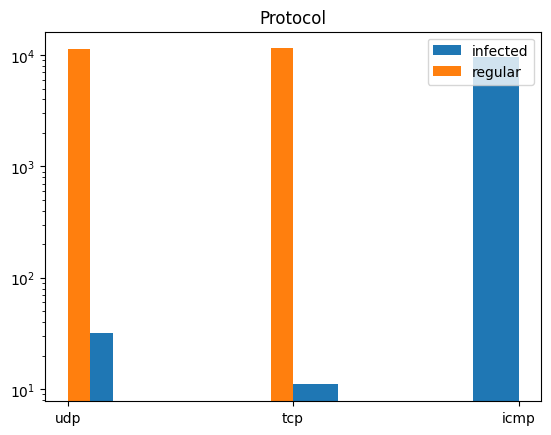

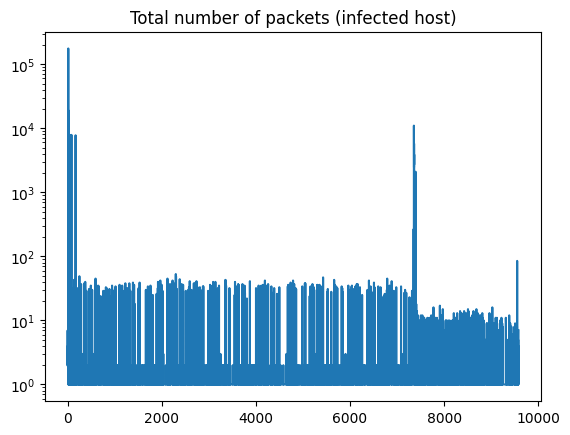

Text(0.5, 1.0, 'Total number of packets (regular)')

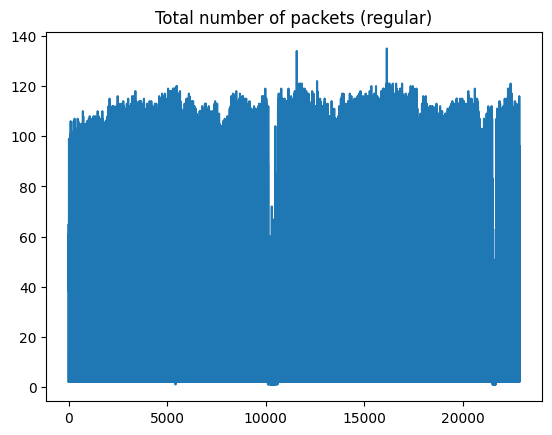

In [6]:
protocol = infected_data['Proto']
total_packets = infected_data['TotPkts']
protocol_normal = non_infected['Proto']
total_packets_normal = non_infected['TotPkts']

plt.hist(protocol, label='infected', log=True)
plt.hist(protocol_normal, label='regular', log=True)
plt.legend()
plt.title("Protocol")
plt.show()

plt.semilogy(range(len(total_packets)), total_packets, label='infected')
plt.title("Total number of packets (infected host)")

plt.show()
plt.plot(range(len(total_packets_normal)), total_packets_normal, label='regular')
plt.title("Total number of packets (regular)")


### 1b. Discretize selected features

In [7]:
def discretize_data(feature_data, num_bins=10, type="bins", percentiles=None):
    if type == "bins":
        bin_boundaries = np.linspace(np.min(feature_data), np.max(feature_data), num_bins)
        bin_indices = np.digitize(feature_data, bin_boundaries)
        return bin_indices
    elif type == "percentile":
        sample = feature_data.sample(frac=0.1, random_state=42)
        percentile_values = np.percentile(np.unique(sorted(total_packets)), percentiles)
        discretized_array = np.digitize(feature_data, percentile_values)
        return discretized_array
    elif type == "SAX":
        sax = SymbolicAggregateApproximation(n_bins=num_bins, strategy='normal')
        saxed_data = sax.transform(feature_data)
        return saxed_data

[  1   2   3   4   5   7   9  11 100]


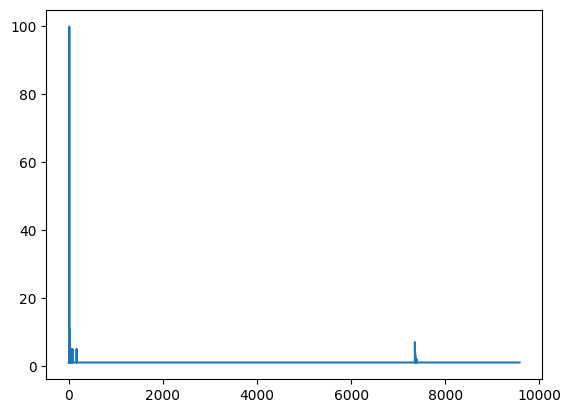

In [8]:
# descrete_duration = descritize_data(protocoll, 20)
# plt.plot(range(len(descrete_duration)), descrete_duration)
# print(np.unique(descrete_duration))
# plt.show()

# bin
discretized_packets = discretize_data(total_packets, 100)
plt.plot(range(len(discretized_packets)), discretized_packets)
print(np.unique(discretized_packets))

[1 2 3]


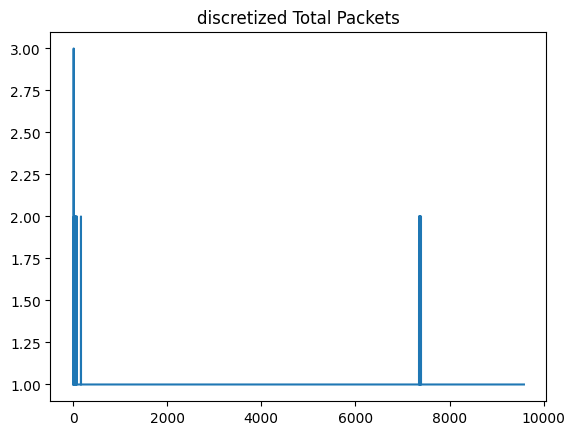

In [9]:
# descrete_duration = descritize_data(duration, type="percentile", percentiles=range(0, 100, 5))
# plt.plot(range(len(descrete_duration)), descrete_duration)
# plt.title("discretized Duration")
# print(np.unique(descrete_duration))
# plt.show()
# percentile
discretized_packets = discretize_data(total_packets, type="percentile", percentiles=[0, 70, 99])
plt.plot(range(len(discretized_packets)), discretized_packets)
plt.title("discretized Total Packets")
print(np.unique(discretized_packets))
plt.show()

# descrete_packets = descritize_data(np.array(total_packets).reshape(-1, 1) , num_bins=10, type="SAX")
# descrete_packets = np.array(descrete_packets)
# plt.plot(range(len(descrete_packets)), descrete_packets)
# plt.title("discretized Total Packets")
# print(np.unique(descrete_packets))
# plt.show()

# np.set_printoptions(suppress=True)
# np.percentile(np.unique(sorted(total_packets)), range(0, 100, 1))

In [10]:
# potential_hosts = data["SrcAddr"][data["Label"].str.contains("Botnet")]
# for add in potential_hosts:
#     infected_data = data[data["SrcAddr"] == add]
#     duration = infected_data['Dur']
#     total_packets = infected_data['TotPkts']
#     plt.plot(range(len(duration)), duration)
#     plt.title("Duration")
#     plt.show()
#     plt.plot(range(len(total_packets)), total_packets)
#     plt.title("Total number of packets")
#     plt.show()
#     input()

In [11]:
# combined_features_mean = np.mean([descrete_duration, descrete_packets], axis=0)
# combined_features_add = descrete_duration + descrete_packets
# plt.plot(range(len(combined_features_mean)), combined_features_mean)
# plt.title("Combined descretized features (mean)")
# plt.show()
# plt.plot(range(len(combined_features_add)), combined_features_add)
# plt.title("Combined descretized features (add)")
# plt.show()

In [12]:
data["Proto"].unique()

array(['tcp', 'udp', 'icmp', 'pim', 'arp', 'ipx/spx', 'rtp', 'rtcp',
       'igmp', 'ipv6-icmp', 'ipv6', 'esp', 'llc', 'udt'], dtype=object)

In [13]:
def attribute_encoding(netflow, M_len):
    features = ['TotPkts','Proto']
    k = len(features)
    
    spaceSize = M_len[0] * M_len[1]    
    code = 0
    for i in range(k):
        code += netflow[features[i]] *  spaceSize/M_len[i]
        spaceSize /= M_len[i]
    return code

# discretize features: protocol and the number of packages to all data
discretized_df = data.copy()

from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder on the column with categorical values
discretized_df['Proto'] = label_encoder.fit_transform(discretized_df['Proto'])
discretized_df['TotPkts'] = discretize_data(discretized_df['TotPkts'], type="percentile", percentiles=[0, 70, 99])

M_len = [len(np.unique(discretized_df.loc[:, 'TotPkts'])), len(np.unique(discretized_df['Proto']))]
print("|M|:",M_len)

discretized_df['encoded'] = discretized_df.apply(lambda row: attribute_encoding(row, M_len), axis=1).astype(int)

print(np.unique(discretized_df['encoded']), len(np.unique(discretized_df['encoded'])))

|M|: [3, 14]
[14 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 34 36 37 39 40 43 53 54] 24


In [14]:
discretized_df

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,encoded
0,2011/08/18 10:21:46.633335,1.060248,11,93.45.239.29,1611,->,147.32.84.118,6881,S_RA,0.0,0.0,1,252,132,flow=Background-TCP-Attempt,25
1,2011/08/18 10:19:49.027650,279.349152,11,62.240.166.118,1031,<?>,147.32.84.229,13363,SRPA_PA,0.0,0.0,1,1318,955,flow=Background-TCP-Attempt,25
2,2011/08/18 10:22:07.160628,166.390015,11,147.32.86.148,58067,->,66.235.132.232,80,SR_SA,0.0,0.0,1,212,134,flow=Background-TCP-Established,25
3,2011/08/18 10:26:02.052163,1.187083,11,147.32.3.51,3130,->,147.32.84.46,10010,S_RA,0.0,0.0,1,244,124,flow=Background-TCP-Attempt,25
4,2011/08/18 10:26:52.226748,0.980571,11,88.212.37.169,3134,->,147.32.84.118,6881,S_RA,0.0,0.0,1,244,124,flow=Background-TCP-Attempt,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309786,2011/08/18 15:04:59.579762,0.000158,11,219.129.213.146,25463,->,147.32.87.44,80,S_SA,0.0,0.0,1,152,78,flow=Background-TCP-Established,25
1309787,2011/08/18 15:04:59.626719,0.000688,12,213.220.104.152,64126,<->,147.32.84.229,13363,CON,0.0,0.0,1,306,244,flow=Background-UDP-Established,26
1309788,2011/08/18 15:04:59.686325,0.000689,12,59.22.11.248,44432,<->,147.32.84.229,13363,CON,0.0,0.0,1,144,83,flow=Background-UDP-Established,26
1309789,2011/08/18 15:04:59.690632,0.000000,12,95.102.170.66,16978,->,147.32.84.229,13363,INT,0.0,NaN,1,172,172,flow=Background-UDP-Attempt,26


### 1c. Answers and explanation

- Based on the plots, the distributions of protocols differ significantly between regular and infected hosts. Notably, icmp protocol is only observed in infected hosts. Additionally, the number of packages for infected hosts tends to be much larger, with values exceeding 1000 or even 10000, while regular hosts typically have values around 100. Therefore, the most relevant features are 'Proto' and 'TotPkts'.

- In conclusion, if the protocol is icmp or the number of packages exceeds 1000, it is highly indicative of a host being infected.

## 2. Sketching task – 1/2 A4 (Individual, 10 Points)

### 2a. COUNT-MIN sketch


### 2b. Analysis and answers to the questions

## 3. Min-wise locality sensitive hashing task – 1/2 A4 (Individual, 10 Points)

### 3a. Implementation

In [15]:
unique_connections = discretized_df.groupby(["SrcAddr", "DstAddr"]).size().reset_index().rename(columns={0:'count'}).sort_values(by="count", ascending=False)
unique_connections[unique_connections['count'] > 20]

,SrcAddr,DstAddr,count
40138,147.32.84.138,147.32.80.9,211823
87121,147.32.84.59,147.32.80.9,77382
110020,147.32.85.25,147.32.80.9,43411
111686,147.32.85.34,147.32.80.9,23248
41966,147.32.84.205,147.32.96.69,11849
...,...,...,...
126820,147.32.86.50,195.113.232.73,21
114189,147.32.86.114,77.78.99.22,21
152817,195.22.243.150,147.32.84.229,21
152818,195.22.42.131,147.32.84.229,21


In [16]:
unique_ips = discretized_df.groupby(["SrcAddr"]).size().reset_index().rename(columns={0:'count'}).sort_values(by="count", ascending=False)
unique_ips[unique_ips['count'] > 20]

,SrcAddr,count
30970,147.32.84.138,211967
31055,147.32.84.59,190698
31031,147.32.84.229,68325
31095,147.32.85.25,43411
30960,147.32.84.118,25228
...,...,...
30824,147.231.37.251,21
74142,41.220.77.56,21
96909,78.100.74.130,21
58103,208.54.86.153,21


In [17]:
# get all unique src -> dst connections sorted by number of rows
unique_connections = discretized_df.groupby(["SrcAddr", "DstAddr"]).size().reset_index().rename(columns={0:'count'}).sort_values(by="count", ascending=False)
# take 50 most common connections to reduce runtime
unique_connections = unique_connections[:10]
src, dst = unique_connections["SrcAddr"].tolist(), unique_connections["DstAddr"].tolist()
n_gram_size = 3
print(unique_connections)

# collect all unique ngrams for later use as rows in the count matrix
unique_ngrams = set()
for conn in zip(src, dst):
    print(conn)
    conn_data = discretized_df[(discretized_df["SrcAddr"] == conn[0]) & (discretized_df["DstAddr"] == conn[1])]["encoded"].tolist()
    three_gram = [conn_data[i:i+n_gram_size] for i in range(len(conn_data)-n_gram_size)]
    for ngram in three_gram:
        unique_ngrams.add(str(ngram))    
print(unique_ngrams)

connections = []
table = []
# loop over all connections
for conn in zip(src, dst):
    connections.append(str(conn))
    occurence = {k:0 for k in unique_ngrams}
    # get combined dicretized feature for current connection
    conn_data = discretized_df[(discretized_df["SrcAddr"] == conn[0]) & (discretized_df["DstAddr"] == conn[1])]["encoded"].tolist()
    # create three grams
    three_gram = [conn_data[i:i+n_gram_size] for i in range(len(conn_data)-n_gram_size)]
    # keep track of 3grams that occur
    for gram in three_gram:
        occurence[str(gram)] = 1
    table.append(occurence.values())

# convert occurence table to dataframe
connection_profiles = pd.DataFrame(table, columns=list(unique_ngrams), index=connections)
connection_profiles

              SrcAddr        DstAddr   count
40138   147.32.84.138    147.32.80.9  211823
87121    147.32.84.59    147.32.80.9   77382
110020   147.32.85.25    147.32.80.9   43411
111686   147.32.85.34    147.32.80.9   23248
41966   147.32.84.205   147.32.96.69   11849
125683   147.32.86.20    147.32.80.9   11395
41976   147.32.84.206   147.32.96.69   11262
41956   147.32.84.204   147.32.96.69   11134
41997   147.32.84.208   147.32.96.69   11093
126270  147.32.86.223  89.221.217.12   10887
('147.32.84.138', '147.32.80.9')
('147.32.84.59', '147.32.80.9')
('147.32.85.25', '147.32.80.9')
('147.32.85.34', '147.32.80.9')
('147.32.84.205', '147.32.96.69')
('147.32.86.20', '147.32.80.9')
('147.32.84.206', '147.32.96.69')
('147.32.84.204', '147.32.96.69')
('147.32.84.208', '147.32.96.69')
('147.32.86.223', '89.221.217.12')
{'[26, 26, 16]', '[54, 40, 40]', '[30, 16, 16]', '[40, 30, 16]', '[40, 40, 16]', '[54, 26, 26]', '[16, 16, 16]', '[16, 16, 26]', '[16, 40, 40]', '[26, 40, 40]', '[16, 30, 16

,"[26, 26, 16]","[54, 40, 40]","[30, 16, 16]","[40, 30, 16]","[40, 40, 16]","[54, 26, 26]","[16, 16, 16]","[16, 16, 26]","[16, 40, 40]","[26, 40, 40]",...,"[40, 40, 30]","[16, 26, 16]","[40, 16, 16]","[16, 30, 30]","[30, 30, 16]","[26, 16, 16]","[30, 16, 30]","[40, 40, 40]","[26, 26, 40]","[16, 16, 30]"
"('147.32.84.138', '147.32.80.9')",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"('147.32.84.59', '147.32.80.9')",1,0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,1,0,0,0,0
"('147.32.85.25', '147.32.80.9')",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"('147.32.85.34', '147.32.80.9')",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"('147.32.84.205', '147.32.96.69')",0,0,1,1,1,1,1,0,1,1,...,1,0,1,1,1,0,0,1,1,1
"('147.32.86.20', '147.32.80.9')",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"('147.32.84.206', '147.32.96.69')",0,1,1,0,1,0,1,0,1,0,...,0,0,1,1,1,0,0,1,0,1
"('147.32.84.204', '147.32.96.69')",0,1,1,1,1,0,1,0,1,0,...,1,0,1,0,0,0,1,1,0,1
"('147.32.84.208', '147.32.96.69')",0,0,1,0,1,1,1,0,1,1,...,0,0,1,1,1,0,1,1,1,1
"('147.32.86.223', '89.221.217.12')",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
def create_signature_matrix(connection_profiles, num_hashes=5):
    def hash_func(x, params, p):
        return (params[0]*x+params[1]) % p

    # fix numpy seed
    np.random.seed(42)

    connection_profiles_tranpose = connection_profiles.T
    num_rows = len(connection_profiles_tranpose)

    # define params for hash functions
    hash_params = []
    for _ in range(num_hashes):
        hash_params.append(np.random.randint(0, num_rows, 2))

    # create slots for signature matrix
    slots = np.full((num_hashes, connection_profiles_tranpose.shape[1]), np.inf)

    # loop over all rows
    for i in range(connection_profiles_tranpose.shape[0]):
        row = connection_profiles_tranpose.iloc[i]
        # loop over all columns
        for j in range(len(row)):
            # if columns is 1 calculate all hashes and select minimum
            if row[j] == 1:
                for x, params in enumerate(hash_params):
                    slots[x][j] = min(slots[x][j], hash_func(i, params, num_rows))

    # convert 2d array to dataframe
    signature_matrix = pd.DataFrame(slots).astype(int)
    return signature_matrix
signature_matrix = create_signature_matrix(connection_profiles)

In [19]:
def column_sim(a, b):
    intersection = sum(x and y for x, y in zip(a, b))
    union = sum(x or y for x, y in zip(a, b))
    return intersection / union

def signature_sim(list1, list2):
    agree = np.sum(list1 == list2)
    return agree/len(list1)


Column 0.125
Signature 0.2
-------------------------
Column 0.125
Signature 0.2
-------------------------
Column 1.0
Signature 1.0
-------------------------
Column 0.058823529411764705
Signature 0.0
-------------------------
Column 0.058823529411764705
Signature 0.0
-------------------------
Column 0.0
Signature 0.0
-------------------------
Column 0.6666666666666666
Signature 0.6
-------------------------
Column 0.5263157894736842
Signature 0.8
-------------------------
Column 0.0
Signature 0.0
-------------------------


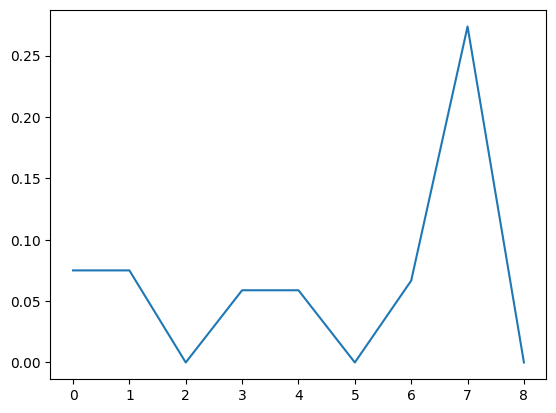

In [20]:
# Compare column similarity with signature similarity
similarity_difference = []
for i in range(len(connection_profiles)-1):
    print("Column", column_sim(connection_profiles.iloc[i], connection_profiles.iloc[i+1]))
    print("Signature", signature_sim(signature_matrix.iloc[:, i], signature_matrix.iloc[:, i+1]))
    print("-"*25)
    similarity_difference.append(np.abs(column_sim(connection_profiles.iloc[i], connection_profiles.iloc[i+1]) - signature_sim(signature_matrix.iloc[:, i], signature_matrix.iloc[:, i+1])))
plt.plot(similarity_difference)

In [21]:
num_buckets = 20
table = {k:[] for k in range(num_buckets)}
# loop over all signatures and bucket them 
for i in range(len(signature_matrix.columns)):
    band = "".join([str(x) for x in list(signature_matrix.iloc[:, i])])
    bucket = hash(band) % num_buckets
    bucket_list = table[bucket]
    bucket_list.append(i)
    table[bucket] = bucket_list
print(table)

{0: [0, 2, 3, 5], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [6, 8], 7: [], 8: [], 9: [], 10: [9], 11: [4, 7], 12: [], 13: [], 14: [], 15: [], 16: [], 17: [1], 18: [], 19: []}


In [22]:
nearest_neighbors = []
# loop over all connections
for i in range(len(connection_profiles)):
    # get candidate profile
    query_profile = connection_profiles.iloc[i]
    max_similarity = -1
    nearest_neighbor = None
    # loop over all connections and determine the closest neighbor using jaccard score
    for j in range(len(connection_profiles)):
        if i != j:
            similarity = jaccard_score(query_profile, connection_profiles.iloc[j])
            if similarity > max_similarity:
                max_similarity = similarity
                nearest_neighbor = j

    nearest_neighbors.append((i, nearest_neighbor))

print("Nearest neighbors:", nearest_neighbors)

Nearest neighbors: [(0, 2), (1, 0), (2, 0), (3, 0), (4, 8), (5, 0), (6, 7), (7, 6), (8, 4), (9, 0)]


In [23]:
def calc_nearest_neighbors_lsh(signature_matrix):
    nearest_neighbors_lsh = []
    # loop over all signatures
    for i in range(len(signature_matrix.columns)):
        query_profile = signature_matrix.iloc[:, i]
        max_similarity = -1
        nearest_neighbor = None
        # determine the nearest neighbor
        for j in range(len(signature_matrix.columns)):
            if i != j:
                similarity = signature_sim(query_profile,  signature_matrix.iloc[:, j])
                if similarity > max_similarity:
                    max_similarity = similarity
                    nearest_neighbor = j

        nearest_neighbors_lsh.append((i, nearest_neighbor))
    return nearest_neighbors_lsh

In [24]:
nearest_neighbors_lsh = calc_nearest_neighbors_lsh(signature_matrix)
percentage_true_neigbor = np.sum(np.array(nearest_neighbors)[:, 1] == np.array(nearest_neighbors_lsh)[:, 1])/len(nearest_neighbors)
print(f"Percentage of true neighbors to signature neighbors: {percentage_true_neigbor*100}%")

Percentage of true neighbors to signature neighbors: 70.0%


Text(0.5, 1.0, 'True neigbors for pairwise comparison')

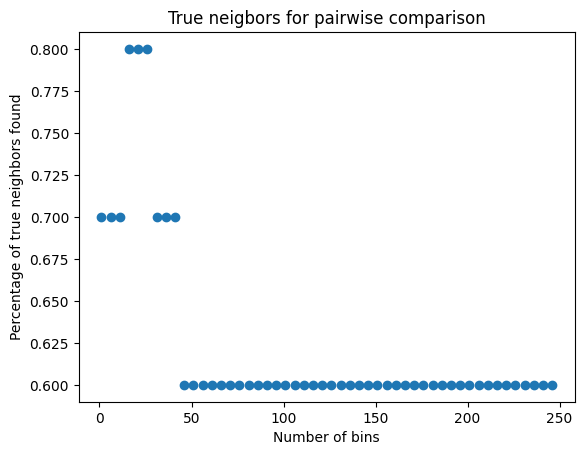

In [25]:
num_bins = np.arange(1, 250, 5)
percentages = []
# loop over bin values
for bin in num_bins:
    # create signature matrix with different number of bins
    signature_matrix = create_signature_matrix(connection_profiles, num_hashes=bin)
    # find nearest neighbor for each signature
    nearest_neighbors_lsh = calc_nearest_neighbors_lsh(signature_matrix)
    # calculate percentage of neighbors that are the same as the true neighbors
    percentage_true_neigbor = np.sum(np.array(nearest_neighbors)[:, 1] == np.array(nearest_neighbors_lsh)[:, 1])/len(nearest_neighbors)
    percentages.append(percentage_true_neigbor)

# plot the bins and percentage of true neighbours found
plt.plot(num_bins, percentages, 'o')
plt.xlabel("Number of bins")
plt.ylabel("Percentage of true neighbors found")
plt.title("True neigbors for pairwise comparison")

In [26]:
def calc_nearest_neighbors_lsh_from_bucket(signature_matrix):
    # calculate nearest neighbors from buckets
    nearest_neighbors_lsh = np.full(len(connection_profiles), -1)
    for bucket_idx, bucket in enumerate(table.values()):        
        if len(bucket) > 1:
            for i in range(len(bucket)):
                candidate = bucket[i]
                query_profile = signature_matrix.iloc[:, candidate]
                nearest_neighbor = 0
                max_sim = -1
                for j in range(len(bucket)):
                    if i != j:
                        sim = signature_sim(query_profile, signature_matrix.iloc[:, bucket[j]])
                        if sim > max_sim:
                            nearest_neighbor = bucket[j]
                            max_sim = sim
                nearest_neighbors_lsh[candidate] = nearest_neighbor
    return nearest_neighbors_lsh
nearest_neighbors_lsh = calc_nearest_neighbors_lsh_from_bucket(signature_matrix)
percentage_true_neighbors = np.sum(np.array(nearest_neighbors)[:, 1] == nearest_neighbors_lsh)/len(nearest_neighbors_lsh)
print(f"Percentage of true neighbors to signature neighbors from Buckets: {percentage_true_neighbors*100}%")

Percentage of true neighbors to signature neighbors from Buckets: 40.0%


Text(0.5, 1.0, 'True neigbors percentage for bucket comparison')

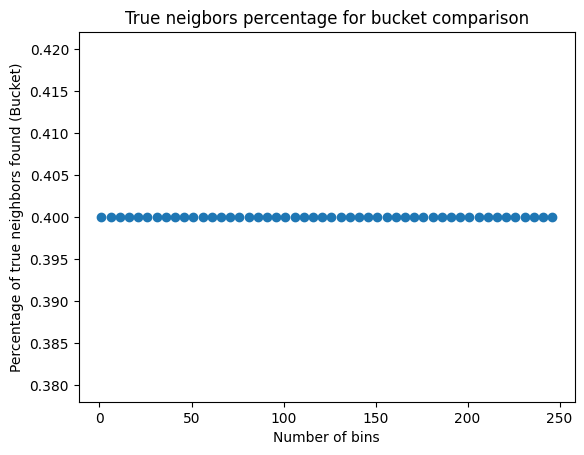

In [27]:
num_bins = np.arange(1, 250, 5)
percentages = []
# loop over bin values
for bin in num_bins:
    # create signature matrix with different number of bins
    signature_matrix = create_signature_matrix(connection_profiles, num_hashes=bin)
    # find nearest neighbor for each signature
    nearest_neighbors_lsh = calc_nearest_neighbors_lsh_from_bucket(signature_matrix)
    # calculate percentage of neighbors that are the same as the true neighbors
    percentage_true_neigbor = np.sum(np.array(nearest_neighbors)[:, 1] == np.array(nearest_neighbors_lsh))/len(nearest_neighbors)
    percentages.append(percentage_true_neigbor)

# plot the bins and percentage of true neighbours found
plt.plot(num_bins, percentages, 'o')
plt.xlabel("Number of bins")
plt.ylabel("Percentage of true neighbors found (Bucket)")
plt.title("True neigbors percentage for bucket comparison")

### 3b. Analysis and answers to the questions

## 4.Botnet profiling and fingerprinting task – 1 A4 (5 Points)

### 4a. Learn a sequential model, profiling and fingerprinting

In [46]:
import json
# Learn sequential model for one infected host
# get all unique src addresses sorted by number of rows
hosts = discretized_df.groupby(["SrcAddr"]).size().reset_index().rename(columns={0:'count'}).sort_values(by="count", ascending=False)
hosts = hosts[hosts["count"] > 20][:10]


tracefile_df = discretized_df[discretized_df["SrcAddr"] == '147.32.84.193'].rename(columns={'encoded': 'symb'})
#tracefile_df = discretized_df[discretized_df["SrcAddr"].isin(hosts["SrcAddr"].values)].rename(columns={'encoded': 'symb'})
benign_host = discretized_df[discretized_df["SrcAddr"] == '147.32.84.164'].rename(columns={'encoded': 'symb'})
infected_host = discretized_df[discretized_df["SrcAddr"] == '147.32.84.204'].rename(columns={'encoded': 'symb'})



flexfringe = FlexFringe(
    flexfringe_path=path_flexfringe,
    heuristic_name="alergia",
    data_name="alergia_data",
    slidingwindow=1, 
    swsize=15, 
    sinkson=1,
    sinkcount=100,
    printblue=1,
    markovian=1
    )

# Learn a state machine
flexfringe.fit(benign_host)
print(flexfringe.json_out)

with open(flexfringe.json_out, 'r') as json_file:
    model_json = json.load(json_file)
    nodes = model_json["nodes"]
    for node in nodes:
        print(node['id'])
        print(node["data"]["trans_counts"])

# Display the learned state machine
flexfringe.show()

# Use state machine to predict likelihoods
df = flexfringe.predict(benign_host)

/tmp/tmpuku1i477.csv.ff.final.json
0
{'16': '139', '25': '189', '26': '399', '39': '17'}
1
{'25': '5', '26': '6', '39': '6'}
2
{'16': '15', '25': '273', '26': '2349', '39': '18'}
3
{'16': '1379', '25': '22', '26': '38'}
7
{'25': '11', '26': '4', '39': '3'}
8
{'16': '17', '25': '289', '26': '238', '39': '9'}
9
{'16': '12', '26': '3'}
10
{'16': '7', '25': '10', '26': '3'}
11
{'16': '3', '25': '3', '26': '32'}
21
{'25': '3', '26': '1', '39': '5'}
22
{'16': '11', '25': '723', '26': '222', '39': '8'}
23
{'16': '3', '25': '74', '26': '542', '39': '3'}
24
{'16': '11', '25': '4', '26': '2'}
53
{'25': '6', '26': '2'}
54
{'16': '7', '25': '1', '26': '2'}
55
{'25': '1', '26': '2'}
56
{'25': '48', '26': '25', '39': '0'}
57
{'16': '1', '25': '192', '26': '293', '39': '28'}
58
{'16': '1', '26': '2'}
114
{'25': '9', '26': '13', '39': '4'}
115
{'16': '11', '25': '111', '26': '196', '39': '5'}
116
{'16': '3', '25': '157', '26': '726', '39': '25'}
117
{'16': '1'}
195
{'25': '1', '39': '3'}
196
{'16': '6

In [29]:
tracefile_df["symb"]

79         25
80         25
81         25
85         25
103        25
           ..
1309776    26
1309777    26
1309778    26
1309779    26
1309790    25
Name: symb, Length: 552901, dtype: int64

### 4b. Analysis and answers to the questions.

## 5. Bonus Task 1/2 A4 (5 Points)

### 5a. Provide implementation and analysis.